# Creating a Kaggle Workflow

In this project, we will create a Kaggle workflow based on the Titanic project. This workflow will help us find the good machine learning model to predict if a person would have survived Titanic's sinking based on his age, sex and other characteristics.

As always with Kaggle's project, we will train our model on the train.csv dataset then test it on the test.csv. Test's file will be named as "holdout" as we'll use "test" variable for internal testing of our model.

First we need to import those files.

In [1]:
import pandas as pd

train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Preprocessing the data

We need to create a dataframe where all the data are numerical in order to perform machine learning.

We will be working with functions that will help us do this job.

In [2]:
def process_missing(df):
    """Handle various missing values from the dataset"""
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process age into bins"""
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1, 0, 5, 12, 18, 35, 60, 100]
    label_names = ["Unknown", "Infant", "Child", "Teenager", "Young Adult", "Adult", "Senior"]
    df["Age_categories"] = pd.cut(df["Age"], cut_points, label_names)
    return df

def process_fare(df):
    """Process fares into bins"""
    cut_points = [-1, 12, 50, 100, 1000]
    label_names = ["0-12", "12-50", "50-100", "100+"]
    df["Fare_categories"] = pd.cut(df["Fare"], cut_points, label_names)
    return df

def process_titles(df):
    """Extract and categorize titles from the name column"""
    titles = {
        "Mr":       "Mr",
        "Mme":      "Mrs",
        "Ms":       "Mrs",
        "Mrs":      "Mrs",
        "Master":   "Master",
        "Mlle":     "Miss",
        "Miss":     "Miss",
        "Capt":     "Officer",
        "Col":      "Officer",
        "Major":    "Officer",
        "Dr":       "Officer",
        "Rev":      "Officer",
        "Jonkheer": "Royalty",
        "Don":      "Royalty",
        "Sir":      "Royalty",
        "Countess": "Royalty",
        "Dona":     "Royalty",
        "Lady":     "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand = False)
    df["Title"] = extracted_titles.map(titles)
    return df

def process_cabin(df):
    """Process cabin into bins only accounting for the first letter of the cabin"""
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop("Cabin", axis = 1)
    return df

def create_dummies(df, column_name):
    """Create dummy columns for categorical variables"""
    dummies = pd.get_dummies(df[column_name], prefix = column_name)
    df = pd.concat([df, dummies], axis = 1)
    return df


In [3]:
def pre_process(df):
    process_missing(df)
    process_age(df)
    process_fare(df)
    process_titles(df)
    process_cabin(df)
    
    for col in ["Age_categories", "Fare_categories", "Title", "Cabin_type", "Sex"]:
        df = create_dummies(df, col)
    
    return df

train = pre_process(train)
holdout = pre_process(holdout)
    

In order to get the best score on Kaggle, we have to work in  a cycle of:
- Data Exploration, to find patterns in the data
- Feature Engineering, to create new features from those patterns or through pure experimentation
- Feature Selection, to select the best subset of our current set of features
- Model Selection/tuning, training a number of models with different hyperparameters to find the best performer
- Kaggle submittal

And start over again.

We will start by taking a look at columns SibSp and Parch, those two refer to the family member each passenger had onboard.

## Exploring the data

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
explore_cols = ["SibSp", "Parch", "Survived"]
explore = train[explore_cols].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
SibSp       891 non-null int64
Parch       891 non-null int64
Survived    891 non-null int64
dtypes: int64(3)
memory usage: 21.0 KB


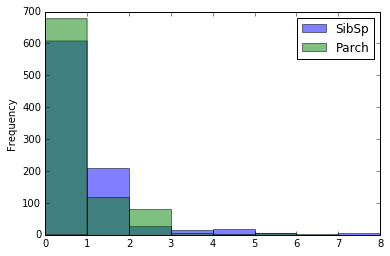

In [6]:
explore.drop("Survived", axis = 1).plot.hist(alpha=0.5, bins = 8)
plt.show()

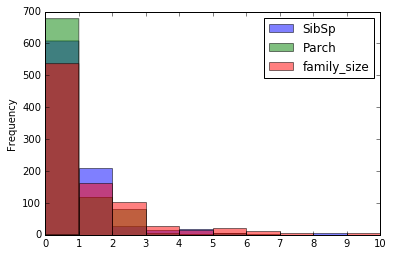

In [7]:
explore["family_size"] = explore[["SibSp","Parch"]].sum(axis=1)
explore.drop("Survived", axis = 1).plot.hist(alpha=0.5, bins = 10)
plt.xticks(range(11))
plt.show()

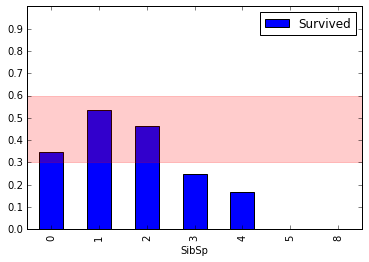

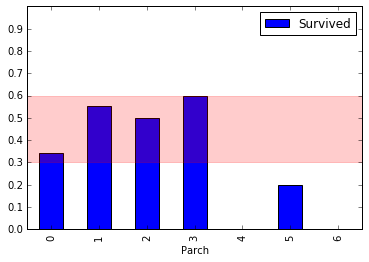

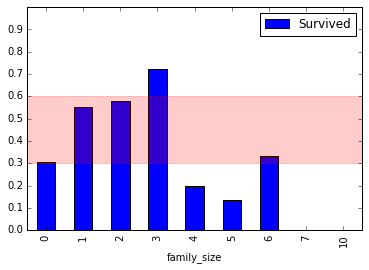

In [8]:
import numpy as np

for col in explore.columns.drop("Survived"):
    pivot = explore.pivot_table(index=col, values = "Survived")
    pivot.plot.bar(ylim=(0,1), yticks=np.arange(0,1,.1))
    plt.axhspan(.3,.6, alpha=0.2, color="red")
    plt.show()


The SibSp column shows the number of siblings and/or spouses each passenger had on board, while the Parch columns shows the number of parents or children each passenger had onboard. Neither column has any missing values.

The distribution of values in both columns is skewed right, with the majority of values being zero.

You can sum these two columns to explore the total number of family members each passenger had onboard. The shape of the distribution of values in this case is similar, however there are less values at zero, and the quantity tapers off less rapidly as the values increase.

Looking at the survival rates of the the combined family members, you can see that few of the over 500 passengers with no family members survived, while greater numbers of passengers with family members survived.

## Engineering New Features

Based of this, we can come up with an idea for a new feature - was the passenger alone. This will be a binary column containing the value:

- 1 if the passenger has zero family members onboard
- 0 if the passenger has one or more family members onboard

In [9]:
def process_isalone(df):
    df["family_size"] = df[["SibSp", "Parch"]].sum(axis = 1)
    df["isalone"] = 0
    df.loc[(df["family_size"] == 0), "isalone"] = 1
    df = df.drop("family_size", axis = 1)
    return df

train = process_isalone(train)
holdout = process_isalone(holdout)

In order to facilitate our features' selection for our machine learning model we can use the feature_selection.RFECV from scikit-learn's.

We will write a function that:
- Accepts a dataframe as input
- Performs data preparation for machine learning
- Uses recursive feature elimination and the random forests algorithm to find the best-performing set of features

## Selecting the Best-Performing Features

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["PassengerId", "Survived"], axis=1)
    all_y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf, cv = 10)
    selector.fit(all_X, all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best columns\n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

cols = select_features(train)

Best columns
------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_(-1, 0]', 'Age_categories_(0, 5]', 'Age_categories_(18, 35]', 'Fare_categories_(12, 50]', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']



/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



## Selecting and Tuning Different Algorithms

We can write a function that will do the job of model selection and tuning. We'll create a function that will use three different algorithms and use grid search to train using different combinations of hyperparameters to find the best performing model.

We will create a list of dictionnaries. Each dictionnary will contain :
- The name of the model
- An estimator for the model
- A dictionnary of hyperparameters used for grid search

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, features):
    all_X = df[features]
    all_y = df["Survived"]
    
    models = [
        {
            #Logistic Regression
            "name" : "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":{
                "solver": ["newton-cg", "lbfgs", "liblinear"]
            } 
        },
        {
            #KNeighborsClassifiers
            "name": "KNeighborsClassifiers",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":{
                "n_neighbors" : range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm" : ["ball_tree", "kd_tree", "brute"],
                "p" : [1,2]
            }
        },
        {
            #RandomForestClassifier
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(),
            "hyperparameters":{
                "n_estimators": [4,6,9],
                "criterion":["entropy", "gini"],
                "max_depth":[2, 5, 10],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": [1, 5, 8],
                "min_samples_split": [2, 3, 5]
            }
        }
    ]
    
    for model in models:
        print("The model is: "+model["name"]+".")
        print("-"*len(model["name"]))
        grid = GridSearchCV(model["estimator"], param_grid = model["hyperparameters"], cv = 10)
        grid.fit(all_X, all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_
        
        print("Best score: {}".format(model["best_score"]))
        print("Best model: {}".format(model["best_model"]))
        
    return models

result = select_model(train, cols)
        

The model is: LogisticRegression.
------------------
Best score: 0.8204264870931538
Best model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
The model is: KNeighborsClassifiers.
---------------------
Best score: 0.7755331088664422
Best model: KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=1,
           weights='uniform')
The model is: RandomForestClassifier.
----------------------
Best score: 0.8372615039281706
Best model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,


We have now three scores from three different models.

Do we want to try it on the holdout set and make a Kaggle submission, or do we want to go back to engineering features.

We can work on a function that will ease the submission to Kaggle if we have to do submissions often.

# Making a Submission to Kaggle

In [19]:
def save_submission_file(model, cols, filename="submission.csv"):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    
    holdout_ids = holdout["PassengerId"]
    
    submission_df = {"PassengerId":holdout_ids,
                              "Survived": predictions}
    submission = pd.DataFrame(submission_df)
    submission.to_csv(filename, index = False)

best_rf_model = result[2]["best_model"]
save_submission_file(best_rf_model, cols)

Our file is now ready to be downloaded and submitted to Kaggle.